In [2]:
import os
import numpy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.font_manager import FontProperties
import pandas as pd
from utils import load_sar_images

from skimage.metrics import structural_similarity as SSIM

In [2]:
def find_gt(filename : str, gts : list) : 
    """
        Given a file name, find the file correspooding to its ground truth
        the ground truth basename must be pile_name.npy
    """

    for gt in gts :
        pile_name = os.path.basename(gt).split('.')[0]
        if pile_name in filename :
            return gt
    return None

def compute_ssim(image1, image2) :
    """
        Compute the ssim value betwenn the two images
    """

    return SSIM(image1,image2,data_range=image2.max() - image2.min())

def compute_psnr(image1, image2) :
    """
        Compute the psnr value betwenn the two images
    """
    image1, image2 = image1.astype(np.float64), image2.astype(np.float64)
    eqm = np.mean((image1 - image2) ** 2)
    d = 255 # assume it was used in their paper

    return 10 * np.log10(d**2 / (eqm+0.01)) # in case eqm = 0

def ssim_psnr_over_files(files_denoised, files_gt, piles, compute_std=False) :
    """
        Computethe psnr and ssim values over the specified files
    """
    ssim = {
        pile : [] for pile in piles
    }
    psnr = {
        pile : [] for pile in piles
    }

    for denoised in files_denoised :
        gt = find_gt(denoised, files_gt)
        if gt : # There is a ground truth associated
            # Open both images
            gt_image = np.load(gt)
            denoised_image = np.load(denoised)
            # Get the pile
            pile_name = os.path.basename(gt).split('.')[0]
            # Compute SSIM
            ssim[pile_name].append(compute_ssim(gt_image, denoised_image))
            # Compute PSNR
            psnr[pile_name].append(compute_psnr(gt_image, denoised_image))
    # Compute mean and std
    ssim_avg = {
    pile_name : {"mean" : np.mean(values),
                "std" : np.std(values)
    } for pile_name, values in ssim.items()
    }
    psnr_avg = {
        pile_name : {"mean" : np.mean(values),
                    "std" : np.std(values)
        } for pile_name, values in psnr.items()
    }
    # SSIM 
    if compute_std :
        values_ssim = [str(round(ssim_avg[p]["mean"],2)) + "±" +  str(round(ssim_avg[p]["std"],4)) for p in piles]
    else :
        values_ssim = [str(round(ssim_avg[p]["mean"],2)) for p in piles]
    # PSNR
    if compute_std :
        values_psnr = [str(round(psnr_avg[p]["mean"],2)) + "±" +  str(round(psnr_avg[p]["std"],4)) for p in piles]
    else :
        values_psnr = [str(round(psnr_avg[p]["mean"],2)) for p in piles]
    return ssim, psnr, values_ssim, values_psnr, ssim_avg, psnr_avg

### With the default argument

Compute the psnr and ssim values, only based on the first prediction of the network (not the change map). There are 10 predictions per pile, and we compute the mean and std.

(0.0, 1.0, 0.0, 1.0)

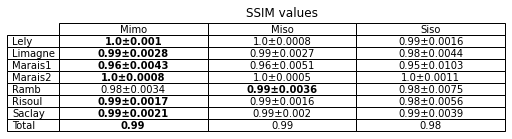

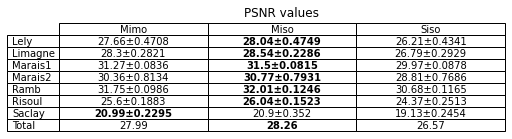

In [146]:
# Store all the results by folder in a dict
groundtruth_folder = "./data_sar/groundtruth/"
files_gt =  glob(groundtruth_folder+'*.npy')
piles = [os.path.basename(gt).split('.')[0] for gt in files_gt]
data_ssim = {
    'Index Title'  : [p.title() for p in piles],
}
data_psnr = {
    'Index Title'  : [p.title() for p in piles],
}

folders = ["mimo_reverse_large","miso_reverse_large","siso_large"]
pile_size_folder = [2,2,1]
for folder,pile_size in zip(folders, pile_size_folder) :
    # Get the images inside the specified folder along with the gt
    data_folder = "./data_sar/{}/".format(folder)
    files_denoised = glob(data_folder+'denoised*.npy')
    # Get the files the model predicted on
    x = load_sar_images("./noisyimages/",pile_size,mode="default")
    # Only the files in the first output
    files_input = x[1]
    files_input = [os.path.basename(f[0]) for f in files_input]
    files_denoised_first = []
    for f in files_denoised :
        for f1 in files_input :
            if "denoised_"+ f1 in f :
                files_denoised_first.append(f)
    files_denoised = files_denoised_first.copy()

    ssim, psnr, values_ssim, values_psnr, ssim_avg, psnr_avg = ssim_psnr_over_files(files_denoised, files_gt, piles, compute_std=True)

    # SSIM
    data_ssim[folder.title().split("_")[0]] = values_ssim
    data_ssim[folder.title().split("_")[0]].append(round(np.mean([ssim_avg[p]["mean"] for p in piles]),2)) # Total mean
    # PSNR
    data_psnr[folder.title().split("_")[0]] = values_psnr
    data_psnr[folder.title().split("_")[0]].append(round(np.mean([psnr_avg[p]["mean"] for p in piles]),2)) # Total mean

data_ssim["Index Title"].append("Total")
data_psnr["Index Title"].append("Total")

# Create the dataframe and display it
df_ssim = pd.DataFrame(data_ssim)
df_ssim.index = df_ssim["Index Title"]
df_ssim.index.name = 'Images'
del df_ssim["Index Title"]
df_ssim.style.set_caption("SSIM values")

plt.figure(figsize = (8, 2))
table = plt.table(cellText = df_ssim.values,
          rowLabels = df_ssim.index,
          colLabels = df_ssim.columns,
          loc = "center",
          cellLoc='center'
         )

for row in range(1,len(piles)+2) :
    idx_max = 0
    val_max = 0
    for col in range(len(folders)) :
        cell = table[row,col]
        if float(cell.get_text()._text.split("±")[0]) > val_max :
            val_max = float(cell.get_text()._text.split("±")[0])
            idx_max = col
    table[row,idx_max].set_text_props(fontproperties=FontProperties(weight='bold'))

plt.title("SSIM values")
plt.axis("off")

df_psnr = pd.DataFrame(data_psnr)
df_psnr.index = df_psnr["Index Title"]
df_psnr.index.name = 'Images'
del df_psnr["Index Title"]

plt.figure(figsize = (8, 2))
table = plt.table(cellText = df_psnr.values,
          rowLabels = df_psnr.index,
          colLabels = df_psnr.columns,
          loc = "center",
          cellLoc='center'
         )
         
for row in range(1,len(piles)+2) :
    idx_max = 0
    val_max = 0
    for col in range(len(folders)) :
        cell = table[row,col]
        if float(cell.get_text()._text.split("±")[0]) > val_max :
            val_max = float(cell.get_text()._text.split("±")[0])
            idx_max = col
    table[row,idx_max].set_text_props(fontproperties=FontProperties(weight='bold'))
plt.title("PSNR values")
plt.axis("off")
    



### With the reverse argument

Like the first problem, we will only consider the first output of the network. But this time the network will be fed with 1-0 instead of 0-1. We will still have 10 outputs, and compute the mean and std.

(0.0, 1.0, 0.0, 1.0)

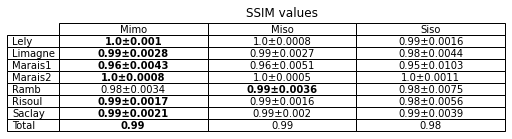

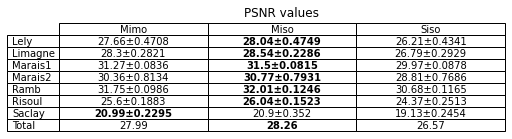

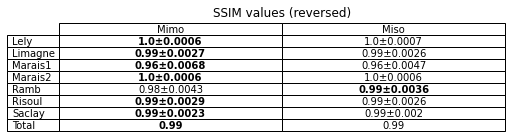

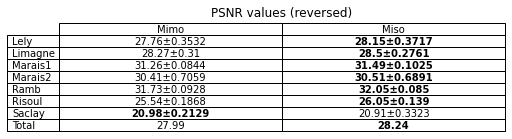

In [58]:
# Display the previous table so we can compare
# Create the dataframe and display it
df_ssim = pd.DataFrame(data_ssim)
df_ssim.index = df_ssim["Index Title"]
df_ssim.index.name = 'Images'
del df_ssim["Index Title"]
df_ssim.style.set_caption("SSIM values")

plt.figure(figsize = (8, 2))
table = plt.table(cellText = df_ssim.values,
          rowLabels = df_ssim.index,
          colLabels = df_ssim.columns,
          loc = "center",
          cellLoc='center'
         )

for row in range(1,len(piles)+2) :
    idx_max = 0
    val_max = 0
    for col in range(len(folders)) :
        cell = table[row,col]
        if float(cell.get_text()._text.split("±")[0]) > val_max :
            val_max = float(cell.get_text()._text.split("±")[0])
            idx_max = col
    table[row,idx_max].set_text_props(fontproperties=FontProperties(weight='bold'))

plt.title("SSIM values")
plt.axis("off")

df_psnr = pd.DataFrame(data_psnr)
df_psnr.index = df_psnr["Index Title"]
df_psnr.index.name = 'Images'
del df_psnr["Index Title"]

plt.figure(figsize = (8, 2))
table = plt.table(cellText = df_psnr.values,
          rowLabels = df_psnr.index,
          colLabels = df_psnr.columns,
          loc = "center",
          cellLoc='center'
         )
         
for row in range(1,len(piles)+2) :
    idx_max = 0
    val_max = 0
    for col in range(len(folders)) :
        cell = table[row,col]
        if float(cell.get_text()._text.split("±")[0]) > val_max :
            val_max = float(cell.get_text()._text.split("±")[0])
            idx_max = col
    table[row,idx_max].set_text_props(fontproperties=FontProperties(weight='bold'))
plt.title("PSNR values")
plt.axis("off")

# Store all the results by folder in a dict
groundtruth_folder = "./data_sar/groundtruth/"
files_gt =  glob(groundtruth_folder+'*.npy')
piles = [os.path.basename(gt).split('.')[0] for gt in files_gt]
data_ssim = {
    'Index Title'  : [p.title() for p in piles],
}
data_psnr = {
    'Index Title'  : [p.title() for p in piles],
}

folders = ["mimo_reverse_large","miso_reverse_large"]
pile_size_folder = [2,2]
for folder,pile_size in zip(folders, pile_size_folder) :
    # Get the images inside the specified folder along with the gt
    data_folder = "./data_sar/{}/".format(folder)
    files_denoised = glob(data_folder+'denoised*.npy')
    # Get the files the model predicted on
    x = load_sar_images("./noisyimages/",pile_size,mode="reverse")
    # Only the files in the first output
    files_input = x[1]
    files_input = [os.path.basename(f[0]) for f in files_input]
    files_denoised_first = []
    for f in files_denoised :
        for f1 in files_input :
            if "denoised_"+ f1 in f and "reverse" in os.path.basename(f):
                files_denoised_first.append(f)
    files_denoised = files_denoised_first.copy()

    ssim, psnr, values_ssim, values_psnr, ssim_avg, psnr_avg = ssim_psnr_over_files(files_denoised, files_gt, piles, compute_std=True)

    # SSIM
    data_ssim[folder.title().split("_")[0]] = values_ssim
    data_ssim[folder.title().split("_")[0]].append(round(np.mean([ssim_avg[p]["mean"] for p in piles]),2)) # Total mean
    # PSNR
    data_psnr[folder.title().split("_")[0]] = values_psnr
    data_psnr[folder.title().split("_")[0]].append(round(np.mean([psnr_avg[p]["mean"] for p in piles]),2)) # Total mean

data_ssim["Index Title"].append("Total")
data_psnr["Index Title"].append("Total")

# Create the dataframe and display it
df_ssim = pd.DataFrame(data_ssim)
df_ssim.index = df_ssim["Index Title"]
df_ssim.index.name = 'Images'
del df_ssim["Index Title"]
df_ssim.style.set_caption("SSIM values")

plt.figure(figsize = (8, 2))
table = plt.table(cellText = df_ssim.values,
          rowLabels = df_ssim.index,
          colLabels = df_ssim.columns,
          loc = "center",
          cellLoc='center'
         )

for row in range(1,len(piles)+2) :
    idx_max = 0
    val_max = 0
    for col in range(len(folders)) :
        cell = table[row,col]
        if float(cell.get_text()._text.split("±")[0]) > val_max :
            val_max = float(cell.get_text()._text.split("±")[0])
            idx_max = col
    table[row,idx_max].set_text_props(fontproperties=FontProperties(weight='bold'))

plt.title("SSIM values (reversed)")
plt.axis("off")

df_psnr = pd.DataFrame(data_psnr)
df_psnr.index = df_psnr["Index Title"]
df_psnr.index.name = 'Images'
del df_psnr["Index Title"]

plt.figure(figsize = (8, 2))
table = plt.table(cellText = df_psnr.values,
          rowLabels = df_psnr.index,
          colLabels = df_psnr.columns,
          loc = "center",
          cellLoc='center'
         )
         
for row in range(1,len(piles)+2) :
    idx_max = 0
    val_max = 0
    for col in range(len(folders)) :
        cell = table[row,col]
        if float(cell.get_text()._text.split("±")[0]) > val_max :
            val_max = float(cell.get_text()._text.split("±")[0])
            idx_max = col
    table[row,idx_max].set_text_props(fontproperties=FontProperties(weight='bold'))
plt.title("PSNR values (reversed)")
plt.axis("off")
    



### Reversed mode : comparison

We will compare the pairs of images and their predictions 0-1 with 1-0 for instance.

In [80]:
folder = "mimo_reverse_large"
pile_size = 2

# Compute the pairs of images (let's store in pairs the pairs of images for file_0 and file_1 (for predictions 0-1 and 1-0))
data_folder = "./data_sar/{}/".format(folder)
files_denoised = glob(data_folder+'denoised*.npy')
# Get the files the model predicted on
x = load_sar_images("./noisyimages/",pile_size,mode="reverse")
# Only the files in the first output
files_input = x[1]
files_input = [os.path.basename(f[0]) for f in files_input]
files_denoised_first = []
for f in files_denoised :
    for f1 in files_input :
        if "denoised_"+ f1 in f :
            files_denoised_first.append(f)
files_denoised = files_denoised_first.copy()

pairs = []
pairs_files = [[os.path.basename(f[0]),os.path.basename(f[1])]  for f in x[1] if not "reversed" in os.path.basename(f[1])]
for f1,f2 in pairs_files :
    file1 = ""
    file2 = ""
    for files in files_denoised :
        if f1 in files :
            file1 = files
        if f2 in files :
            file2 = files
    pairs.append([file1,file2])

# Let's take a random pair
ss = []
ps = []
for pair in pairs :
    prediction_correct = np.load(pair[0])
    prediction_reverse = np.load(pair[1])
    ss.append(compute_ssim(prediction_correct,prediction_reverse))
    ps.append(compute_psnr(prediction_correct,prediction_reverse))

"SSIM = {} ± {} - PSNR = {} ± {}".format(np.mean(ss), np.std(ss), np.mean(ps), np.std(ps))



'SSIM = 0.9980658193725952 ± 0.0016157573695308753 - PSNR = 35.03305780829439 ± 2.801208798622027'

### All mode : Compare

We will compare the different prediction (0-1 0-2 0-3 0-4 0-5 0-6 0-7)

In [144]:
folder = "mimo_all_large"
pile_size = 2

# Compute the pairs of images (let's store in pairs the pairs of images for file_0 and file_1 (for predictions 0-1 and 1-0))
data_folder = "./data_sar/{}/".format(folder)
files_denoised = glob(data_folder+'denoised*.npy')
# Get the files the model predicted on
x = load_sar_images("./noisyimages/",pile_size,mode="all")
# Only the files in the first output
files_input = x[1]
files_input = [os.path.basename(f[0]) for f in files_input]
files_denoised_first = []
for f in files_denoised :
    for f1 in files_input :
        if "denoised_"+ f1 in f :
            files_denoised_first.append(f)
files_denoised = files_denoised_first.copy()

# Let's check for all piles that the results are close
pile_all = {
    pile : []
    for pile in piles
}
for pile in piles :
    for files in files_denoised :
        if pile in files :
            pile_all[pile].append(files)

pile_values = {
    pile : []
    for pile in piles
}

for pile in piles :
    basic = np.load(pile_all[pile][0])
    for im in pile_all[pile][1:] :
        img = np.load(im)
        pile_values[pile].append(compute_ssim(basic,img))
pile_values = {
    p : (np.mean(v), np.std(v)) for p,v in pile_values.items()
}
pile_values

{'lely': (1.0, 0.0),
 'limagne': (1.0, 0.0),
 'marais1': (1.0, 0.0),
 'marais2': (1.0, 0.0),
 'ramb': (1.0, 0.0),
 'risoul': (1.0, 0.0),
 'saclay': (1.0, 0.0)}

### Plot change map !

For a given input, plot the change map and the prediction. This is required to pick a mimo folder.

The brighter the place is, the higher the change map will be !

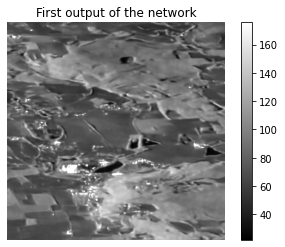

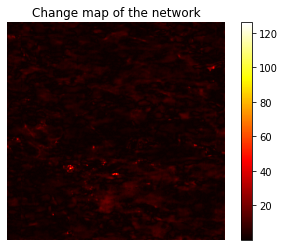

In [221]:
from random import randint

folder = "mimo_reverse_large"
pile_size = 2

data_folder = "./data_sar/{}/".format(folder)
files_denoised = glob(data_folder+'denoised*.npy')
# Get the files the model predicted on
x = load_sar_images("./noisyimages/",pile_size,mode="default")
# Only the files in the first output
files_input = x[1]
files_input = [(os.path.basename(f[0]),os.path.basename(f[1])) for f in files_input]

# Pick a random input
inp = files_input[randint(0,len(files_input)-1)]

# Find the correct output
for files in files_denoised :
    if "denoised_" + inp[0] in files :
        file0 = files
    if "denoised_" + inp[1] in files :
        file1 = files

output = np.load(file0)
change_map = np.abs(np.load(file1) - np.load(file0))

plt.imshow(np.clip(output,np.mean(output)-3* np.std(output), np.mean(output)+3* np.std(output)),cmap='gray')
plt.colorbar()
plt.title("First output of the network")
plt.axis('off')
plt.show()

plt.imshow(change_map,cmap='hot')
plt.colorbar()
plt.title("Change map of the network")
plt.axis('off')
plt.show()


### Display ratio image

Show a ratio image (noisy/denoised).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


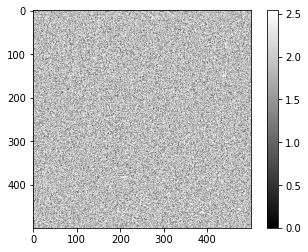

In [42]:
from random import randint

# Select a folder
folder = "miso_reverse_large"
files_denoised = glob(data_folder+'denoised*.png')

# Random file
file_denoised = files_denoised[randint(0, len(files_denoised)-1)]
file_noisy = file_denoised.replace("denoised","noisy")
file_noisy, file_denoised

ratio = cv2.imread(file_noisy) / cv2.imread(file_denoised)

plt.imshow(ratio,cmap="gray",vmin=np.amin(ratio), vmax=np.amax(ratio))
plt.colorbar()
plt.show()


### Gif over a pile

Use the png as it it better visually.

In [10]:
from PIL import Image
from IPython import display

pile_name = "saclay"
folder = "mimo_reverse_large"
fn = 'png_to_gif{}{}.gif'.format(pile_name,folder)

data_folder = "./data_sar/{}/".format(folder)
files_denoised = glob(data_folder+'denoised*.png')

files_denoised = [f for f in files_denoised if pile_name in f and not "all" in f and not "reversed" in f]

frames = []
for i in files_denoised:
    new_frame = Image.open(i)
    frames.append(new_frame)

frames[0].save(fn, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

display.HTML('<img src="{}">'.format(fn))